In [1]:
import os 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_images_as_array(path_to_dir, suffix='.png'):
    '''Returns images in the given directory (based on the suffix) as numpy array'''
    images = []

    for filename in os.listdir(path_to_dir):
        if filename.endswith(suffix):
            img = Image.open(os.path.join(path_to_dir, filename))
            images.append(np.array(img))
    
    return np.array(images)

In [3]:
patches_path = '../dataset/training_patches'
labels_path = '../dataset/training_noisy_labels'

patches = load_images_as_array(patches_path)
labels = load_images_as_array(labels_path)

print(patches.shape)
print(labels.shape)

(5000, 256, 256, 3)
(5000, 256, 256)


In [4]:
# Use labels to mask input patches 
labels_3ch = np.repeat(labels[..., np.newaxis], 3, axis=3) # repeat the mask for all 3 channels 
masked_patches = np.ma.masked_where(labels_3ch == 0, patches) # mask patches 
filled_patches = masked_patches.filled(0) # fill masked pixels with 0 -> black 

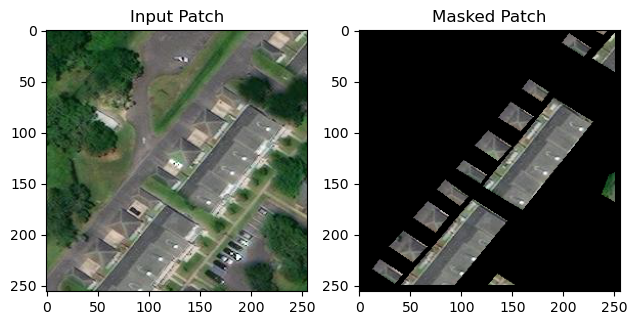

In [5]:
# plot pair of images 
fig, axs = plt.subplots(1, 2)
axs[0].imshow(patches[0, ...])
axs[1].imshow(filled_patches[0, ...])
axs[0].set_title('Input Patch')
axs[1].set_title('Masked Patch')
plt.tight_layout()
plt.show()

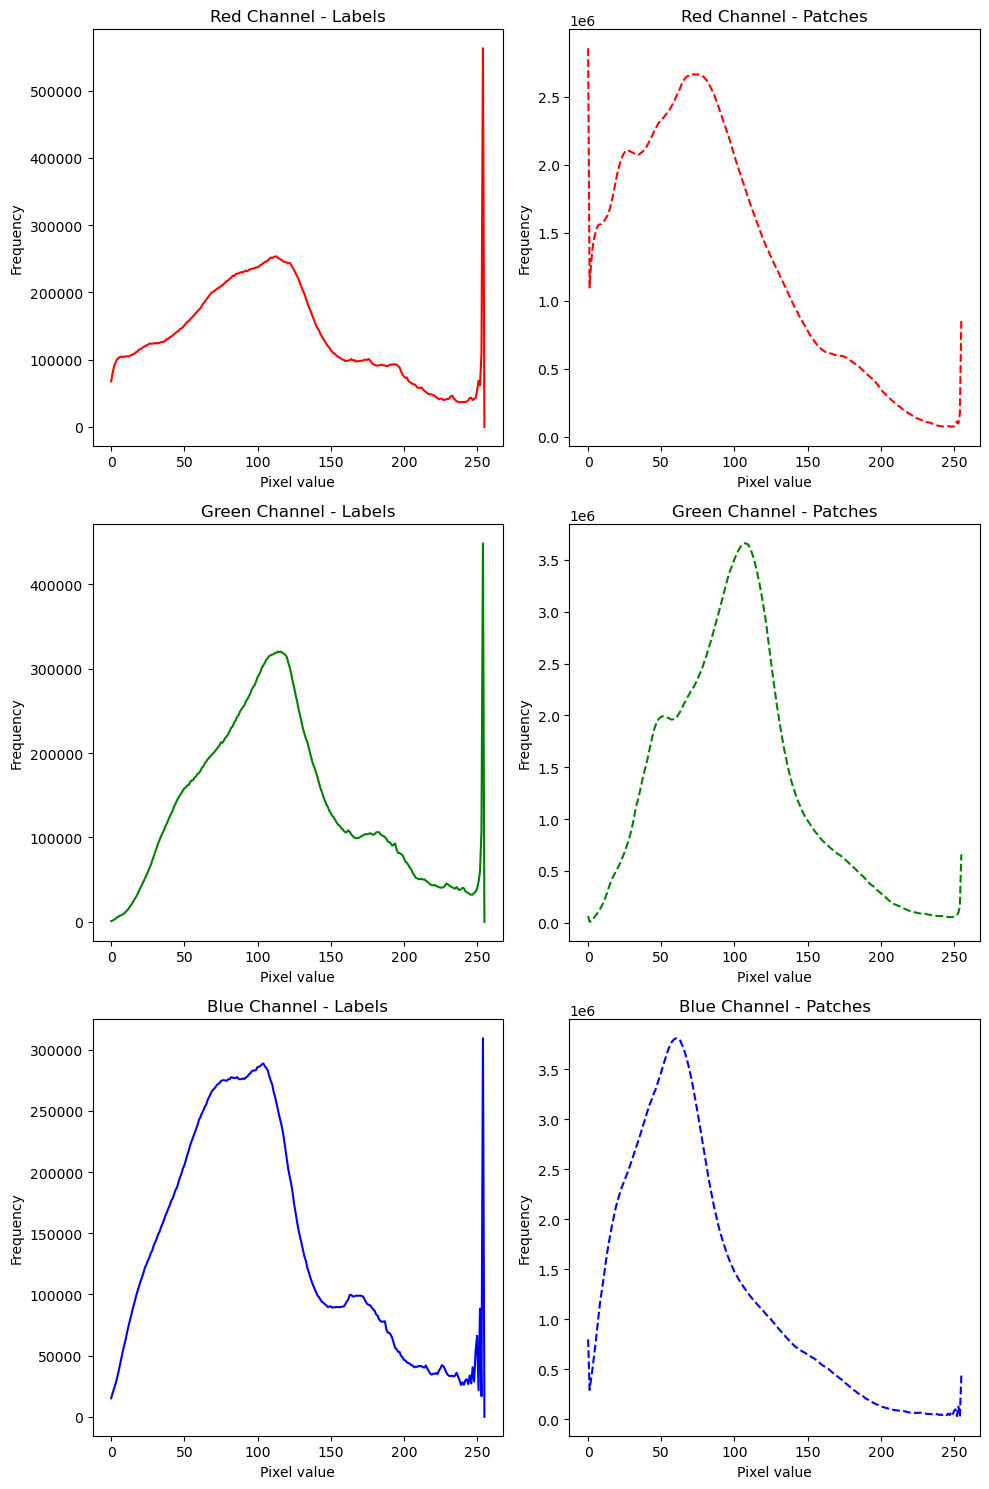

In [6]:
# Calculate histograms for each channel - label
hist_red_labels = np.histogram(filled_patches[..., 0], bins=256, range=(1, 256))[0]
hist_green_labels = np.histogram(filled_patches[..., 1], bins=256, range=(1, 256))[0]
hist_blue_labels = np.histogram(filled_patches[..., 2], bins=256, range=(1, 256))[0]

# Calculate histograms for each channel - full
hist_red_patch = np.histogram(patches[..., 0], bins=256, range=(0, 256))[0]
hist_green_patch = np.histogram(patches[..., 1], bins=256, range=(0, 256))[0]
hist_blue_patch = np.histogram(patches[..., 2], bins=256, range=(0, 256))[0]

# Plot the histograms using subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

axs[0, 0].plot(hist_red_labels, color='red')
axs[0, 0].set_title('Red Channel - Labels')
axs[0, 0].set_xlabel('Pixel value')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].plot(hist_red_patch, color='red', linestyle='dashed')
axs[0, 1].set_title('Red Channel - Patches')
axs[0, 1].set_xlabel('Pixel value')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].plot(hist_green_labels, color='green')
axs[1, 0].set_title('Green Channel - Labels')
axs[1, 0].set_xlabel('Pixel value')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].plot(hist_green_patch, color='green', linestyle='dashed')
axs[1, 1].set_title('Green Channel - Patches')
axs[1, 1].set_xlabel('Pixel value')
axs[1, 1].set_ylabel('Frequency')

axs[2, 0].plot(hist_blue_labels, color='blue')
axs[2, 0].set_title('Blue Channel - Labels')
axs[2, 0].set_xlabel('Pixel value')
axs[2, 0].set_ylabel('Frequency')

axs[2, 1].plot(hist_blue_patch, color='blue', linestyle='dashed')
axs[2, 1].set_title('Blue Channel - Patches')
axs[2, 1].set_xlabel('Pixel value')
axs[2, 1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

# t-SNE

In [7]:
import torch
import torchvision.models as models
from torchvision import transforms

from tqdm import tqdm


In [8]:
resnet34 = models.resnet34(weights='DEFAULT')
encoder = torch.nn.Sequential(*list(resnet34.children())[:-1]) 

In [9]:
preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [10]:
_ = encoder.eval()

pil_images = []
for img in patches: # full patches here 
    pil_images.append(Image.fromarray(img))

batch_size = 16
all_features = []

with torch.no_grad():
    for i in tqdm(range(0, len(pil_images), batch_size), desc="Processing batches"):
        batch_images = pil_images[i:i + batch_size]
        # Preprocess the batch 
        batch_tensors = torch.stack([preprocess(img) for img in batch_images])
        # Forward pass through the encoder
        features = encoder(batch_tensors)
        # Flatten the features
        features = features.view(features.size(0), -1)
        all_features.append(features)

# Concatenate all features
encoded_patches = torch.cat(all_features, dim=0)


Processing batches: 100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


In [11]:
encoded_patches_arr = encoded_patches.numpy()
np.save('encoded_patches.npy', encoded_patches_arr)

In [12]:
_ = encoder.eval()
pil_images = []
for img in filled_patches: # masks here (filled patches with 0s where masks == 0)
    pil_images.append(Image.fromarray(img))

batch_size = 16
all_features = []

with torch.no_grad():
    for i in tqdm(range(0, len(pil_images), batch_size), desc="Processing batches"):
        batch_images = pil_images[i:i + batch_size]
        # Preprocess the batch 
        batch_tensors = torch.stack([preprocess(img) for img in batch_images])

        # Forward pass through the encoder
        features = encoder(batch_tensors)
        # Flatten the features
        features = features.view(features.size(0), -1)
        all_features.append(features)

# Concatenate all features
encoded_mask = torch.cat(all_features, dim=0)

Processing batches: 100%|██████████| 313/313 [02:11<00:00,  2.39it/s]


In [13]:
encoded_mask_arr = encoded_mask.numpy()
np.save('encoded_masks.npy', encoded_mask_arr)

In [14]:
from sklearn.manifold import TSNE

In [16]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_patch_30 = tsne.fit_transform(encoded_patches_arr)
tsne_mask_30 = tsne.fit_transform(encoded_mask_arr)

In [17]:
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_patch_50 = tsne.fit_transform(encoded_patches_arr)
tsne_mask_50 = tsne.fit_transform(encoded_mask_arr)

In [18]:
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
tsne_patch_100 = tsne.fit_transform(encoded_patches_arr)
tsne_mask_100 = tsne.fit_transform(encoded_mask_arr)

In [19]:
df_patch_30 = pd.DataFrame(tsne_patch_30, columns=['CP1', 'CP2'])
df_patch_50 = pd.DataFrame(tsne_patch_50, columns=['CP1', 'CP2'])
df_patch_100 = pd.DataFrame(tsne_patch_100, columns=['CP1', 'CP2'])
df_mask_30 = pd.DataFrame(tsne_mask_30, columns=['CP1', 'CP2'])
df_mask_50 = pd.DataFrame(tsne_mask_50, columns=['CP1', 'CP2'])
df_mask_100 = pd.DataFrame(tsne_mask_100, columns=['CP1', 'CP2'])

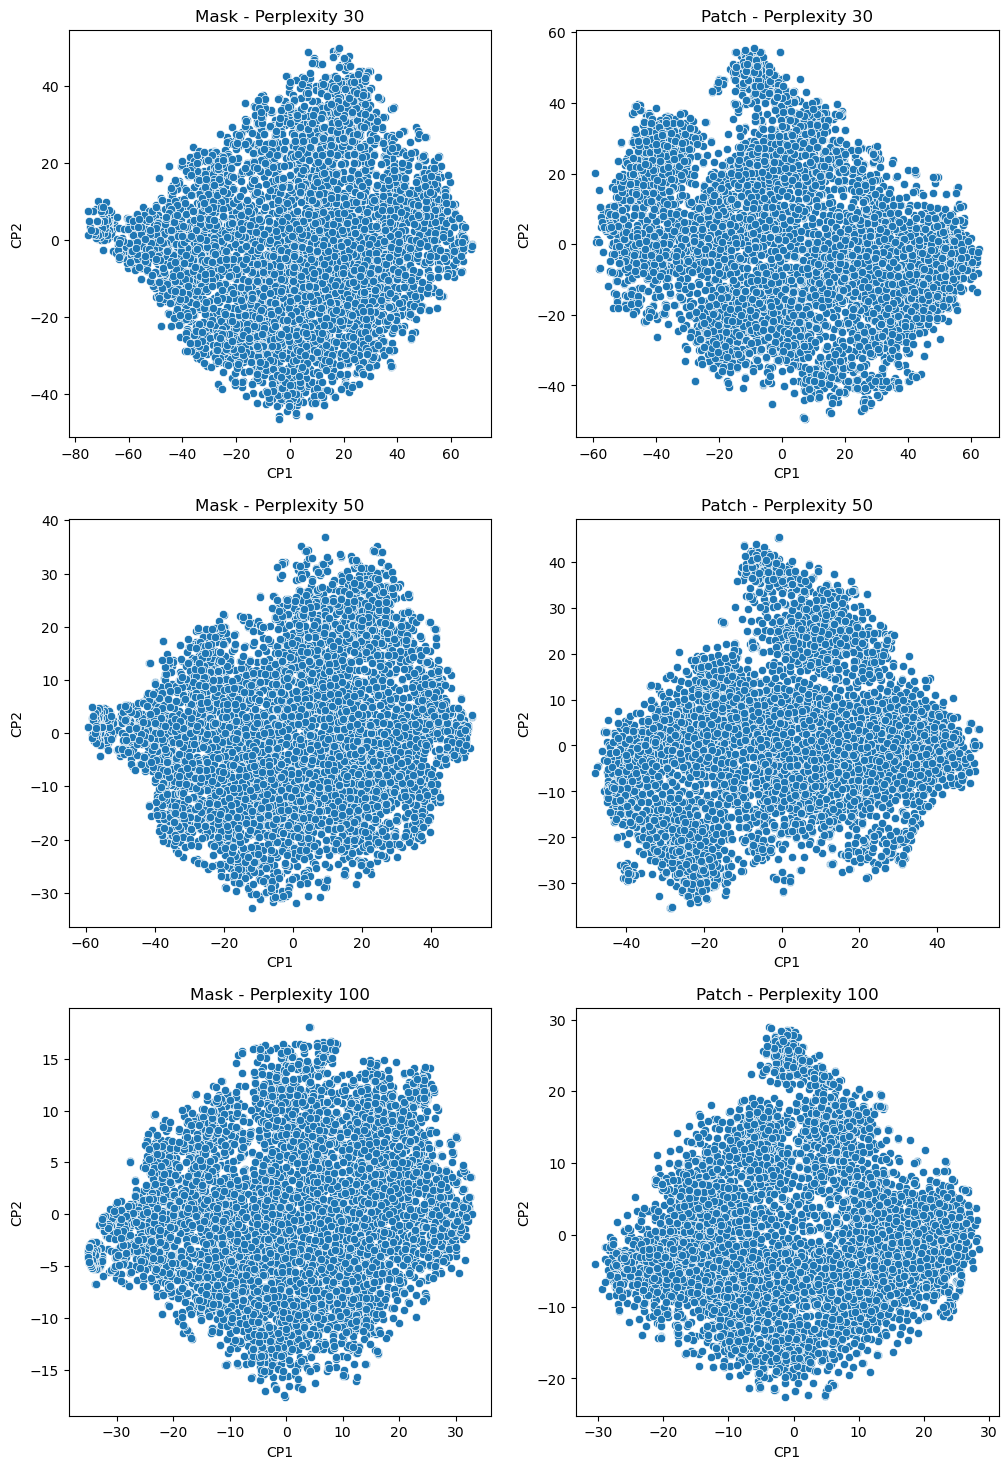

In [20]:
import seaborn as sns 

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

sns.scatterplot(data=df_mask_30, x='CP1', y='CP2', ax=axs[0, 0])
axs[0, 0].set_title('Mask - Perplexity 30')

sns.scatterplot(data=df_patch_30, x='CP1', y='CP2', ax=axs[0, 1])
axs[0, 1].set_title('Patch - Perplexity 30')

sns.scatterplot(data=df_mask_50, x='CP1', y='CP2', ax=axs[1, 0])
axs[1, 0].set_title('Mask - Perplexity 50')

sns.scatterplot(data=df_patch_50, x='CP1', y='CP2', ax=axs[1, 1])
axs[1, 1].set_title('Patch - Perplexity 50')

sns.scatterplot(data=df_mask_100, x='CP1', y='CP2', ax=axs[2, 0])
axs[2, 0].set_title('Mask - Perplexity 100')

sns.scatterplot(data=df_patch_100, x='CP1', y='CP2', ax=axs[2, 1])
axs[2, 1].set_title('Patch - Perplexity 100')

plt.show()


In [4]:
encoded_patches = np.load('encoded_patches.npy')

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_encoded_patches = tsne.fit_transform(encoded_patches)

<Axes: >

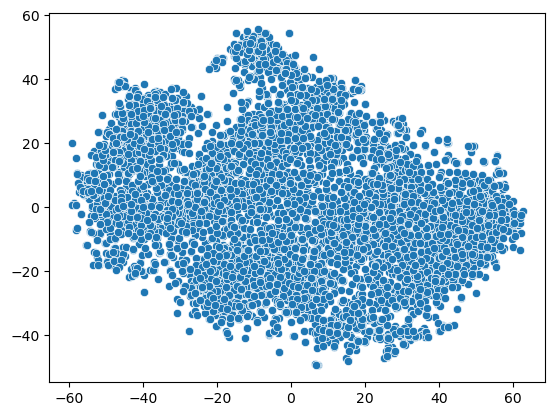

In [7]:
import seaborn as sns 
sns.scatterplot(x=tsne_encoded_patches[:, 0], y=tsne_encoded_patches[:, 1])